# **MRI Brain Alzheimer Classification - Dino V2**

**Clone Dataset from GitHub**

In [1]:
# Check if the directory exists and clone if it does not
# !if [ ! -d "MRI_Brain_Alzheimer_Classification" ]; then git clone https://github.com/nivbartov/MRI_Brain_Alzheimer_Classification; fi

# Change directory to the cloned repository
# %cd MRI_Brain_Alzheimer_Classification
%cd ..

c:\Dor\TECHNION\deep_learning\Project\MRI_Barin_Alzheimer_Classification


**Import Packages**

In [2]:
# Suppress user and future warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# imports
import sys
import os
import numpy as np
import pandas as pd
import torch
from torchsummary import summary
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Subset, ConcatDataset
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from kornia import augmentation as K
from kornia.augmentation import AugmentationSequential
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import random
import time
from datetime import datetime
import json


# repository imports
from models import def_models
from utils import utils_funcs
from utils import optuna_search


**Device Definition**

In [3]:
# check if there is a CUDA device available 
print(f'torch.cuda.is_available(): {torch.cuda.is_available()}')

# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')
torch.cuda.empty_cache()

torch.cuda.is_available(): True
device: cuda:0


**Load the Dataset**

In [4]:
train_set = torch.load('dataset/dataset_variables/train_set.pt')
validation_set = torch.load('dataset/dataset_variables/validation_set.pt')
test_set = torch.load('dataset/dataset_variables/test_set.pt')

**Model Definition and Initialization**

In [5]:
# Initialize in,out channels, width and height sizes
width = 224
height = 224
input_channels = 3
output_channels = 4

dino_v2_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')

# freeze dino_v2 layers
for param in dino_v2_model.parameters():
    param.requires_grad = False
    

# make the model
model = def_models.DINO_v2_FT(dino_backbone=dino_v2_model, output_channels=output_channels).to(device)

Using cache found in C:\Users\97252/.cache\torch\hub\facebookresearch_dinov2_main


**Pre-processing of the data**

In [6]:
# Resize images from 128x128 to 224x224 transformation
preprocess = transforms.Compose([
    transforms.Resize((width, height)),
    transforms.ToTensor()
])

# Apply transformations to the datasets
train_set = utils_funcs.apply_transformations(train_set, preprocess)
validation_set = utils_funcs.apply_transformations(validation_set, preprocess)
test_set = utils_funcs.apply_transformations(test_set, preprocess)

**Model Statistics**

In [7]:
# model statistics
model_name = type(model).__name__
print("model ", model_name," statistics")
summary(model, (input_channels, height, width))

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

model  DINO_v2_FT  statistics
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 384, 16, 16]         226,176
          Identity-2             [-1, 256, 384]               0
        PatchEmbed-3             [-1, 256, 384]               0
         LayerNorm-4             [-1, 257, 384]             768
            Linear-5            [-1, 257, 1152]         443,520
            Linear-6             [-1, 257, 384]         147,840
           Dropout-7             [-1, 257, 384]               0
   MemEffAttention-8             [-1, 257, 384]               0
        LayerScale-9             [-1, 257, 384]               0
        LayerNorm-10             [-1, 257, 384]             768
           Linear-11            [-1, 257, 1536]         591,360
             GELU-12            [-1, 257, 1536]               0
          Dropout-13            [-1, 257, 1536]               0
         

**Session Directory**

In [8]:
# current_time = datetime.now().strftime("%H%M%S_%d%m%Y")  # Format: HHMMSS_DDMMYYYY
# session_dir = f"./checkpoints/{model_name}_session_{current_time}"
# os.makedirs(session_dir, exist_ok=True)
# print(f"Saving session to: {session_dir}")

**Optuna**

In [9]:
params = optuna_search.optuna_param_search(model_name="DINO_v2_FT", loss_criterion=nn.CrossEntropyLoss(), num_epochs_for_experiments=10, device=device,transfer_learning=True)
print(params)

[I 2024-10-02 23:23:54,097] A new study created in memory with name: mri-alzhimer-classification


Optuna is done on device: cuda:0


Using cache found in C:\Users\97252/.cache\torch\hub\facebookresearch_dinov2_main
100%|██████████| 10/10 [09:37<00:00, 57.70s/it]
[I 2024-10-02 23:33:47,102] Trial 0 finished with value: 0.6171875 and parameters: {'lr': 0.001008330978170977, 'optimizer': 'SGD', 'batch_size': 128, 'scheduler': 'StepLR'}. Best is trial 0 with value: 0.6171875.
Using cache found in C:\Users\97252/.cache\torch\hub\facebookresearch_dinov2_main
100%|██████████| 10/10 [05:58<00:00, 35.87s/it]
[I 2024-10-02 23:40:01,525] Trial 1 finished with value: 0.7541666666666667 and parameters: {'lr': 3.878851801197722e-05, 'optimizer': 'Adam', 'batch_size': 32, 'scheduler': 'CosineAnnealingLR'}. Best is trial 1 with value: 0.7541666666666667.
Using cache found in C:\Users\97252/.cache\torch\hub\facebookresearch_dinov2_main
100%|██████████| 10/10 [06:04<00:00, 36.49s/it]
[I 2024-10-02 23:46:21,232] Trial 2 finished with value: 0.625 and parameters: {'lr': 9.640761996979857e-06, 'optimizer': 'Adam', 'batch_size': 32, 'sch

Study statistics: 
  Number of finished trials:  45
  Number of pruned trials:  24
  Number of complete trials:  21
Best trial:
  Value:  0.928125
  Params: 
    lr: 8.052984216230575e-05
    optimizer: RMSprop
    batch_size: 128
    scheduler: CosineAnnealingLR
Best parameters saved to checkpoints/op_tuna_params\DINO_v2_FT\DINO_v2_FT_0.9281.json
{'lr': 8.052984216230575e-05, 'optimizer': 'RMSprop', 'batch_size': 128, 'scheduler': 'CosineAnnealingLR'}


**Load best Hyper Parameters**

In [10]:
# op_tuna_params_path = f'./checkpoints/op_tuna_params/{model_name}/DINO_v2_FT_0.9109.json'

# print("Retrieving op_tuna params...")

# with open(op_tuna_params_path, 'r') as file:
#     params = json.load(file)

# # Hyper-parameters
# batch_size = params['batch_size']
# learning_rate = params['lr']
# optimizer_name = params['optimizer']
# scheduler = params['scheduler']

# print(f'Batch Size: {batch_size}')
# print(f'Learning Rate: {learning_rate}')
# print(f'Optimizer Name: {optimizer_name}')
# print(f'Scheduler Name: {scheduler}')


**Hyper-Parameters**

In [11]:
# Hyper-parameters
batch_size = params['batch_size']
learning_rate = params['lr']
optimizer_name = params['optimizer']
scheduler = params['scheduler']

num_epochs = 50

# loss criterion
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = getattr(torch.optim, optimizer_name)(model.fc.parameters(), lr=learning_rate)

# scheduler
scheduler = StepLR(optimizer, 10, 0.1, verbose=True) if scheduler == "StepLR" else CosineAnnealingLR(optimizer, num_epochs, verbose=True)


augmentations = K.AugmentationSequential(
        K.RandomHorizontalFlip(p=0.1),
        K.RandomVerticalFlip(p=0.1),
        K.RandomRotation(degrees=10, p=0.1),
        K.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05), p=0.1),
        K.RandomBrightness(brightness=(0.8, 1.2), p=0.1),
        K.RandomContrast(contrast=(0.8, 1.2), p=0.1),
        K.RandomGamma(gamma=(0.9, 1.1), p=0.1),
        K.RandomSharpness(p=0.1),
        same_on_batch=False
)


**Prepare the data**

In [12]:
# Combine train_set and val_set into one dataset and
combined_train_val_set = ConcatDataset([train_set, validation_set])

# Loading the data and shuffling it
trainloader = torch.utils.data.DataLoader(combined_train_val_set, batch_size=batch_size, shuffle=True, num_workers=4,pin_memory=True)
testloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4,pin_memory=True)

**Load fine-tuned parameters**

In [13]:
# model_path = './checkpoints/DINO_v2_FT_070051_02102024.pth'
# checkpoint = torch.load(model_path,weights_only=True)
# last_epoch, last_loss = utils_funcs.load_model(model, optimizer, model_path)
# model.load_state_dict(checkpoint['net'])

**Train Model**

In [14]:
epoch_losses = utils_funcs.train(model, num_epochs, trainloader, device, criterion, optimizer, scheduler, augmentations)

Training model: DINO_v2_FT on cuda:0


Epoch 1/50: 100%|██████████| 40/40 [03:03<00:00,  4.60s/it]


Epoch: 1 | Loss: 0.9435 | Training accuracy: 80.391% | Epoch Time: 282.06 secs


Epoch 2/50: 100%|██████████| 40/40 [01:46<00:00,  2.67s/it]


Epoch: 2 | Loss: 0.6457 | Training accuracy: 90.215% | Epoch Time: 239.25 secs


Epoch 3/50: 100%|██████████| 40/40 [02:56<00:00,  4.42s/it]


Epoch: 3 | Loss: 0.4967 | Training accuracy: 94.121% | Epoch Time: 278.55 secs


Epoch 4/50: 100%|██████████| 40/40 [01:34<00:00,  2.35s/it]


Epoch: 4 | Loss: 0.4043 | Training accuracy: 95.449% | Epoch Time: 318.88 secs


Epoch 5/50: 100%|██████████| 40/40 [01:13<00:00,  1.84s/it]


Epoch: 5 | Loss: 0.3386 | Training accuracy: 97.148% | Epoch Time: 175.87 secs


Epoch 6/50: 100%|██████████| 40/40 [02:10<00:00,  3.26s/it]


Epoch: 6 | Loss: 0.2881 | Training accuracy: 98.574% | Epoch Time: 256.66 secs


Epoch 7/50: 100%|██████████| 40/40 [02:23<00:00,  3.58s/it]


Epoch: 7 | Loss: 0.2441 | Training accuracy: 99.355% | Epoch Time: 283.69 secs


Epoch 8/50: 100%|██████████| 40/40 [01:58<00:00,  2.95s/it]


Epoch: 8 | Loss: 0.2114 | Training accuracy: 99.805% | Epoch Time: 208.25 secs


Epoch 9/50: 100%|██████████| 40/40 [01:26<00:00,  2.16s/it]


Epoch: 9 | Loss: 0.1936 | Training accuracy: 99.766% | Epoch Time: 188.80 secs


Epoch 10/50: 100%|██████████| 40/40 [03:22<00:00,  5.07s/it]


Epoch: 10 | Loss: 0.1745 | Training accuracy: 99.766% | Epoch Time: 287.61 secs
==> Saving model ...
saved as ./checkpoints/DINO_v2_FT_063015_03102024.pth


Epoch 11/50: 100%|██████████| 40/40 [01:30<00:00,  2.26s/it]


Epoch: 11 | Loss: 0.1693 | Training accuracy: 99.883% | Epoch Time: 211.62 secs


Epoch 12/50: 100%|██████████| 40/40 [02:09<00:00,  3.23s/it]


Epoch: 12 | Loss: 0.1471 | Training accuracy: 99.863% | Epoch Time: 227.30 secs


Epoch 13/50: 100%|██████████| 40/40 [01:37<00:00,  2.43s/it]


Epoch: 13 | Loss: 0.1411 | Training accuracy: 99.980% | Epoch Time: 226.66 secs


Epoch 14/50: 100%|██████████| 40/40 [01:20<00:00,  2.02s/it]


Epoch: 14 | Loss: 0.1358 | Training accuracy: 100.000% | Epoch Time: 197.25 secs


Epoch 15/50: 100%|██████████| 40/40 [02:57<00:00,  4.45s/it]


Epoch: 15 | Loss: 0.1204 | Training accuracy: 99.922% | Epoch Time: 277.43 secs


Epoch 16/50: 100%|██████████| 40/40 [01:26<00:00,  2.15s/it]


Epoch: 16 | Loss: 0.1174 | Training accuracy: 99.980% | Epoch Time: 204.23 secs


Epoch 17/50: 100%|██████████| 40/40 [02:31<00:00,  3.79s/it]


Epoch: 17 | Loss: 0.1080 | Training accuracy: 100.000% | Epoch Time: 272.04 secs


Epoch 18/50: 100%|██████████| 40/40 [01:21<00:00,  2.03s/it]


Epoch: 18 | Loss: 0.1068 | Training accuracy: 100.000% | Epoch Time: 217.16 secs


Epoch 19/50: 100%|██████████| 40/40 [02:32<00:00,  3.81s/it]


Epoch: 19 | Loss: 0.0935 | Training accuracy: 100.000% | Epoch Time: 328.38 secs


Epoch 20/50: 100%|██████████| 40/40 [01:16<00:00,  1.90s/it]


Epoch: 20 | Loss: 0.0919 | Training accuracy: 100.000% | Epoch Time: 246.23 secs
==> Saving model ...
saved as ./checkpoints/DINO_v2_FT_071023_03102024.pth


Epoch 21/50: 100%|██████████| 40/40 [03:30<00:00,  5.25s/it]


Epoch: 21 | Loss: 0.0838 | Training accuracy: 100.000% | Epoch Time: 346.22 secs


Epoch 22/50: 100%|██████████| 40/40 [01:58<00:00,  2.95s/it]


Epoch: 22 | Loss: 0.0828 | Training accuracy: 99.980% | Epoch Time: 218.18 secs


Epoch 23/50: 100%|██████████| 40/40 [03:44<00:00,  5.62s/it]


Epoch: 23 | Loss: 0.0816 | Training accuracy: 100.000% | Epoch Time: 389.49 secs


Epoch 24/50: 100%|██████████| 40/40 [01:23<00:00,  2.09s/it]


Epoch: 24 | Loss: 0.0785 | Training accuracy: 99.980% | Epoch Time: 192.05 secs


Epoch 25/50: 100%|██████████| 40/40 [02:49<00:00,  4.24s/it]


Epoch: 25 | Loss: 0.0858 | Training accuracy: 100.000% | Epoch Time: 310.05 secs


Epoch 26/50: 100%|██████████| 40/40 [02:19<00:00,  3.49s/it]


Epoch: 26 | Loss: 0.0714 | Training accuracy: 99.980% | Epoch Time: 266.92 secs


Epoch 27/50: 100%|██████████| 40/40 [03:19<00:00,  4.99s/it]


Epoch: 27 | Loss: 0.0734 | Training accuracy: 100.000% | Epoch Time: 288.53 secs


Epoch 28/50: 100%|██████████| 40/40 [01:28<00:00,  2.20s/it]


Epoch: 28 | Loss: 0.0657 | Training accuracy: 100.000% | Epoch Time: 202.00 secs


Epoch 29/50: 100%|██████████| 40/40 [01:58<00:00,  2.97s/it]


Epoch: 29 | Loss: 0.0695 | Training accuracy: 100.000% | Epoch Time: 253.67 secs


Epoch 30/50: 100%|██████████| 40/40 [01:41<00:00,  2.53s/it]


Epoch: 30 | Loss: 0.0693 | Training accuracy: 100.000% | Epoch Time: 227.27 secs
==> Saving model ...
saved as ./checkpoints/DINO_v2_FT_075518_03102024.pth


Epoch 31/50: 100%|██████████| 40/40 [01:38<00:00,  2.45s/it]


Epoch: 31 | Loss: 0.0485 | Training accuracy: 100.000% | Epoch Time: 256.12 secs


Epoch 32/50: 100%|██████████| 40/40 [01:43<00:00,  2.59s/it]


Epoch: 32 | Loss: 0.0635 | Training accuracy: 100.000% | Epoch Time: 229.91 secs


Epoch 33/50: 100%|██████████| 40/40 [01:44<00:00,  2.61s/it]


Epoch: 33 | Loss: 0.0538 | Training accuracy: 100.000% | Epoch Time: 231.57 secs


Epoch 34/50: 100%|██████████| 40/40 [01:58<00:00,  2.95s/it]


Epoch: 34 | Loss: 0.0585 | Training accuracy: 100.000% | Epoch Time: 249.20 secs


Epoch 35/50: 100%|██████████| 40/40 [01:47<00:00,  2.69s/it]


Epoch: 35 | Loss: 0.0512 | Training accuracy: 100.000% | Epoch Time: 227.89 secs


Epoch 36/50: 100%|██████████| 40/40 [01:49<00:00,  2.75s/it]


Epoch: 36 | Loss: 0.0507 | Training accuracy: 100.000% | Epoch Time: 239.09 secs


Epoch 37/50: 100%|██████████| 40/40 [01:49<00:00,  2.75s/it]


Epoch: 37 | Loss: 0.0506 | Training accuracy: 100.000% | Epoch Time: 243.32 secs


Epoch 38/50: 100%|██████████| 40/40 [01:58<00:00,  2.97s/it]


Epoch: 38 | Loss: 0.0469 | Training accuracy: 100.000% | Epoch Time: 246.60 secs


Epoch 39/50: 100%|██████████| 40/40 [01:45<00:00,  2.63s/it]


Epoch: 39 | Loss: 0.0535 | Training accuracy: 100.000% | Epoch Time: 247.08 secs


Epoch 40/50: 100%|██████████| 40/40 [02:23<00:00,  3.58s/it]


Epoch: 40 | Loss: 0.0440 | Training accuracy: 100.000% | Epoch Time: 290.80 secs
==> Saving model ...
saved as ./checkpoints/DINO_v2_FT_083619_03102024.pth


Epoch 41/50: 100%|██████████| 40/40 [01:53<00:00,  2.83s/it]


Epoch: 41 | Loss: 0.0483 | Training accuracy: 100.000% | Epoch Time: 259.40 secs


Epoch 42/50: 100%|██████████| 40/40 [01:59<00:00,  2.98s/it]


Epoch: 42 | Loss: 0.0476 | Training accuracy: 100.000% | Epoch Time: 273.88 secs


Epoch 43/50: 100%|██████████| 40/40 [01:45<00:00,  2.63s/it]


Epoch: 43 | Loss: 0.0476 | Training accuracy: 100.000% | Epoch Time: 230.40 secs


Epoch 44/50: 100%|██████████| 40/40 [01:43<00:00,  2.59s/it]


Epoch: 44 | Loss: 0.0453 | Training accuracy: 100.000% | Epoch Time: 238.64 secs


Epoch 45/50: 100%|██████████| 40/40 [01:23<00:00,  2.09s/it]


Epoch: 45 | Loss: 0.0388 | Training accuracy: 100.000% | Epoch Time: 210.33 secs


Epoch 46/50: 100%|██████████| 40/40 [01:23<00:00,  2.10s/it]


Epoch: 46 | Loss: 0.0453 | Training accuracy: 100.000% | Epoch Time: 205.50 secs


Epoch 47/50: 100%|██████████| 40/40 [01:22<00:00,  2.07s/it]


Epoch: 47 | Loss: 0.0445 | Training accuracy: 100.000% | Epoch Time: 207.16 secs


Epoch 48/50: 100%|██████████| 40/40 [01:18<00:00,  1.96s/it]


Epoch: 48 | Loss: 0.0456 | Training accuracy: 100.000% | Epoch Time: 197.77 secs


Epoch 49/50: 100%|██████████| 40/40 [01:17<00:00,  1.95s/it]


Epoch: 49 | Loss: 0.0462 | Training accuracy: 100.000% | Epoch Time: 195.58 secs


Epoch 50/50: 100%|██████████| 40/40 [01:22<00:00,  2.07s/it]


Epoch: 50 | Loss: 0.0416 | Training accuracy: 100.000% | Epoch Time: 183.82 secs
==> Saving model ...
saved as ./checkpoints/DINO_v2_FT_091302_03102024.pth


**Results**

<Figure size 800x600 with 0 Axes>

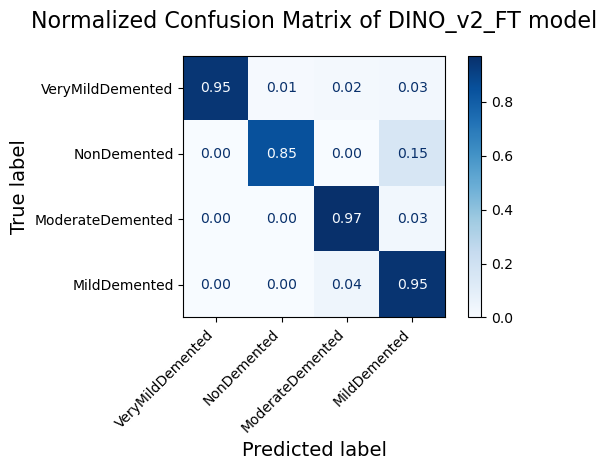

In [15]:
class_names = ['VeryMildDemented', 'NonDemented', 'ModerateDemented', 'MildDemented']
utils_funcs.plot_normalized_confusion_matrix(testloader, model, class_names, device, model_name)

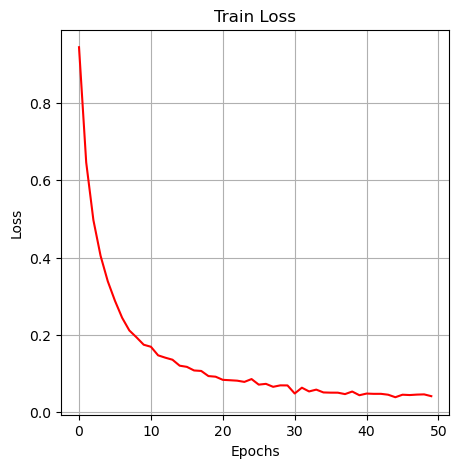

In [16]:
utils_funcs.plot_loss_curve(epoch_losses, num_epochs)

In [17]:
test_accuracy = utils_funcs.calculate_accuracy(model, testloader, device)
print("Test accuracy: {:.3f}%".format(test_accuracy))

Test accuracy: 96.094%
